Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import pickle
import time
import os

Load repository characteristics dataset

In [2]:
df_repo = pd.read_csv('./characteristics_repo.csv')
print(df_repo.columns)

Index(['full_name', 'is_fork', 'has_issues', 'created_at', 'last_modified',
       'pushed_at', 'main_language', 'total_issues_count', 'open_issues_count',
       'closed_issues_count', 'total_pull_requests_count',
       'open_pull_requests_count', 'closed_pull_requests_count', 'size',
       'topics', 'stargazers_count', 'subscribers_count', 'forks_count',
       'commits_count', 'assignees_count', 'branches_count', 'releases_count',
       'is_archive', 'has_wiki', 'contributors_count', 'open_issues_countv2',
       'closed_issues_countv2', 'total_issues_countv2', 'has_IRT'],
      dtype='object')


Retrieve the features we are interested in 

In [3]:
df_repo = df_repo[['main_language', 'total_issues_count', 'total_pull_requests_count','commits_count','branches_count', 'contributors_count', 'has_IRT']]

In [4]:
print(df_repo.columns)

Index(['main_language', 'total_issues_count', 'total_pull_requests_count',
       'commits_count', 'branches_count', 'contributors_count', 'has_IRT'],
      dtype='object')


Divide the dataset into two. One that contains repositories with IRTs, one that contains those that don't 

In [5]:
df_repo_hasIRT = df_repo[df_repo['has_IRT'] == True]
df_repo_hasIRT.shape

(50032, 7)

In [6]:
df_repo_noIRT = df_repo[df_repo['has_IRT'] == False]
df_repo_noIRT.shape

(1034268, 7)

Set those repositories that have IRTs in training and testing holdouts.
* 80% is in training
* 20% is in testing

In [7]:
df_repo_hasIRT_train = df_repo_hasIRT[:int(df_repo_hasIRT.shape[0] * 0.8)]
df_repo_hasIRT_test = df_repo_hasIRT[int(df_repo_hasIRT.shape[0] * 0.8):]
df_repo_hasIRT_train.shape, df_repo_hasIRT_test.shape

((40025, 7), (10007, 7))

Set those repositories that do not have IRTs in training and testing holdouts
* As many as df_repo_hasIRT_train in training (to make the dataset balanced)
* All the rest

In [8]:
df_repo_noIRT_train = df_repo_noIRT[:df_repo_hasIRT_train.shape[0]]
df_repo_noIRT_test = df_repo_noIRT[df_repo_hasIRT_train.shape[0]:]
df_repo_noIRT_train.shape, df_repo_noIRT_test.shape

((40025, 7), (994243, 7))

Combine the datasets into training and testing holdouts 

In [9]:
df_repo_train = pd.concat([df_repo_hasIRT_train, df_repo_noIRT_train], ignore_index=True)
df_repo_test = pd.concat([df_repo_hasIRT_test, df_repo_noIRT_test], ignore_index=True)
df_repo_train.shape, df_repo_test.shape

((80050, 7), (1004250, 7))

Train an SVM model with the training dataset and assess its performance with the testing dataset. However, the main_language and has_IRT attributes of the datasets are of type string and boolean respectively. Convert these into values instead for training and testing

Get all distinct programming languages in the training dataset. Check if there is any missing data

In [10]:
main_lang_train = df_repo_train['main_language'].unique()
df_repo_train['main_language'].isna().any(), len(df_repo_train['main_language'].unique())

(False, 130)

Get all distinct programming languages in the testing dataset. Check if there is any missing data

In [11]:
main_lang_test = df_repo_test['main_language'].unique()
df_repo_test['main_language'].isna().any(), len(df_repo_test['main_language'].unique())

(False, 282)

Find all distinct programming languages in the training and testing datasets together

In [12]:
main_langs = set(main_lang_train).union(set(main_lang_test))
main_langs = np.array(list(main_langs))
main_langs.shape

(294,)

Map programming languages to integers

In [13]:
lang_encodings = LabelEncoder()
lang_encodings.fit_transform(main_langs)
lang_encodings = dict(zip(lang_encodings.classes_, lang_encodings.transform(lang_encodings.classes_)))
lang_encodings

{'1C Enterprise': 0,
 'AGS Script': 1,
 'AIDL': 2,
 'AMPL': 3,
 'ANTLR': 4,
 'API Blueprint': 5,
 'ASL': 6,
 'ASP.NET': 7,
 'ActionScript': 8,
 'Ada': 9,
 'Adblock Filter List': 10,
 'AngelScript': 11,
 'Antlers': 12,
 'Apex': 13,
 'AppleScript': 14,
 'Arduino': 15,
 'AsciiDoc': 16,
 'Assembly': 17,
 'Astro': 18,
 'AutoHotkey': 19,
 'AutoIt': 20,
 'BASIC': 21,
 'Ballerina': 22,
 'Batchfile': 23,
 'Beef': 24,
 'Berry': 25,
 'Bicep': 26,
 'Bikeshed': 27,
 'BitBake': 28,
 'Blade': 29,
 'Boogie': 30,
 'Brainfuck': 31,
 'BrighterScript': 32,
 'C': 33,
 'C#': 34,
 'C++': 35,
 'CAP CDS': 36,
 'CLIPS': 37,
 'CMake': 38,
 'COBOL': 39,
 'CSON': 40,
 'CSS': 41,
 'CUE': 42,
 'Cadence': 43,
 'Cairo': 44,
 "Cap'n Proto": 45,
 'ChucK': 46,
 'Clarity': 47,
 'Classic ASP': 48,
 'Click': 49,
 'Clojure': 50,
 'CodeQL': 51,
 'CoffeeScript': 52,
 'Common Lisp': 53,
 'Common Workflow Language': 54,
 'Coq': 55,
 'Crystal': 56,
 'Csound': 57,
 'Cuda': 58,
 'Cypher': 59,
 'Cython': 60,
 'D': 61,
 'DIGITAL Comm

Update the main_language column of training and test holdouts accordingly using the mapping provided above

In [14]:
temp_train = np.array(df_repo_train['main_language'])
temp_test = np.array(df_repo_test['main_language'])

for i in range(len(temp_train)):
    temp_train[i] = lang_encodings[temp_train[i]]

for i in range(len(temp_test)):
    temp_test[i] = lang_encodings[temp_test[i]]
    

Update the training dataset so that main_language is of type integer

In [15]:
df_repo_train.loc[:, 'main_language'] = temp_train
df_repo_train[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,183,747.0,330.0,3010.0,313.0,17.0,True
1,96,515.0,391.0,502.0,32.0,35.0,True
2,201,84.0,60.0,237.0,1.0,2.0,True
3,96,77.0,73.0,246.0,1.0,4.0,True
4,64,91.0,46.0,167.0,1.0,14.0,True
5,119,482.0,324.0,761.0,16.0,39.0,True
6,119,1991.0,1320.0,4236.0,5.0,84.0,True
7,201,554.0,292.0,528.0,11.0,50.0,True
8,35,102.0,25.0,2164.0,2.0,2.0,True
9,120,60.0,5.0,150.0,1.0,2.0,True


Update the testing dataset so that main_language is of type integer

In [16]:
df_repo_test.loc[:, 'main_language'] = temp_test
df_repo_test[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,35,1026.0,675.0,1403.0,14.0,51.0,True
1,250,134.0,96.0,968.0,2.0,1.0,True
2,201,154.0,143.0,138.0,10.0,18.0,True
3,201,163.0,84.0,481.0,12.0,16.0,True
4,201,2173.0,1390.0,1456.0,11.0,138.0,True
5,258,23.0,14.0,131.0,4.0,4.0,True
6,258,376.0,373.0,743.0,2.0,4.0,True
7,35,46.0,31.0,78.0,1.0,3.0,True
8,120,5420.0,753.0,3114.0,12.0,250.0,True
9,120,2144.0,866.0,2887.0,33.0,225.0,True


has_IRT attribute will act as the domain in this case. Consider those repositories that have IRT as in domain 1 and others in domain 0. Apply this for both training and testing datasets

In [17]:
df_repo_train['has_IRT'] = np.where(df_repo_train['has_IRT'], 1, 0) 
df_repo_test['has_IRT'] = np.where(df_repo_test['has_IRT'], 1, 0)

In [18]:
df_repo_train[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,183,747.0,330.0,3010.0,313.0,17.0,1
1,96,515.0,391.0,502.0,32.0,35.0,1
2,201,84.0,60.0,237.0,1.0,2.0,1
3,96,77.0,73.0,246.0,1.0,4.0,1
4,64,91.0,46.0,167.0,1.0,14.0,1
5,119,482.0,324.0,761.0,16.0,39.0,1
6,119,1991.0,1320.0,4236.0,5.0,84.0,1
7,201,554.0,292.0,528.0,11.0,50.0,1
8,35,102.0,25.0,2164.0,2.0,2.0,1
9,120,60.0,5.0,150.0,1.0,2.0,1


In [19]:
df_repo_test[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,35,1026.0,675.0,1403.0,14.0,51.0,1
1,250,134.0,96.0,968.0,2.0,1.0,1
2,201,154.0,143.0,138.0,10.0,18.0,1
3,201,163.0,84.0,481.0,12.0,16.0,1
4,201,2173.0,1390.0,1456.0,11.0,138.0,1
5,258,23.0,14.0,131.0,4.0,4.0,1
6,258,376.0,373.0,743.0,2.0,4.0,1
7,35,46.0,31.0,78.0,1.0,3.0,1
8,120,5420.0,753.0,3114.0,12.0,250.0,1
9,120,2144.0,866.0,2887.0,33.0,225.0,1


Initialize SVM models to be trained

In [20]:
svm_classifiers = [svm.SVC(kernel='rbf') for i in range(df_repo_train.shape[1]-1)]
print(svm_classifiers)

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]


Train the models. Each SVM model's parameters will be stored in the current working director so that it can be loaded and used later

In [21]:
domain_train = np.array(df_repo_train.iloc[:, df_repo_train.shape[1]-1])
for i in range(len(svm_classifiers)):
    if not os.path.exists(f'./svm_{df_repo_train.columns[0]}.pkl'):
        feature = np.array(df_repo_train.iloc[:,i]).reshape(-1,1)
        start = time.time()
        svm_classifiers[i].fit(feature, domain_train)
        stop = time.time()
        with open(f'svm_{df_repo_train.columns[i]}.pkl','wb') as f:
            pickle.dump(svm_classifiers[i],f)
        print(f'**** Saved svm_{df_repo_train.columns[i]} in {os.getcwd()} [Training Time = {(stop - start) / 60}min] ****')

Models are saved in the current working directory. Retrieve them to assess their performance

In [22]:
for i in range(len(svm_classifiers)):
    with open(f'svm_{df_repo_train.columns[i]}.pkl', 'rb') as f:
        svm_classifiers[i] = pickle.load(f)

Assess the performance of the models with the test holdout and compute their accuracy

In [23]:
domain_test = np.array(df_repo_test.iloc[:10**3, df_repo_test.shape[1]-1])
for i in range(len(svm_classifiers)):
    feature = np.array(df_repo_test.iloc[:10**3,i]).reshape(-1,1)
    domain_pred = svm_classifiers[i].predict(feature)
    accuracy = accuracy_score(domain_test, domain_pred)
    print(f"Accuracy: svm_{df_repo_test.columns[i]}", accuracy)

Accuracy: svm_main_language 0.265
Accuracy: svm_total_issues_count 0.598
Accuracy: svm_total_pull_requests_count 0.563
Accuracy: svm_commits_count 0.523
Accuracy: svm_branches_count 0.447
Accuracy: svm_contributors_count 0.598


Set the significance threshold to reject null hypothesis for the statistical tests to be conducted

In [24]:
significance = 0.05

Map programming languages to integers

In [25]:
temp_IRT = np.array(df_repo_hasIRT['main_language'])
temp_noIRT = np.array(df_repo_noIRT['main_language'])

for i in range(len(temp_IRT)):
    temp_IRT[i] = lang_encodings[temp_IRT[i]]

for i in range(len(temp_noIRT)):
    temp_noIRT[i] = lang_encodings[temp_noIRT[i]]

Update the datasets accordingly

In [26]:
df_repo_hasIRT.loc[:, 'main_language'] = temp_IRT
df_repo_noIRT.loc[:, 'main_language'] = temp_noIRT

Make it so that the indexes of the datasets start from 0

In [27]:
df_repo_hasIRT.reset_index(drop=True, inplace=True)
df_repo_noIRT.reset_index(drop=True, inplace=True)

In [28]:
df_repo_hasIRT[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,183,747.0,330.0,3010.0,313.0,17.0,True
1,96,515.0,391.0,502.0,32.0,35.0,True
2,201,84.0,60.0,237.0,1.0,2.0,True
3,96,77.0,73.0,246.0,1.0,4.0,True
4,64,91.0,46.0,167.0,1.0,14.0,True
5,119,482.0,324.0,761.0,16.0,39.0,True
6,119,1991.0,1320.0,4236.0,5.0,84.0,True
7,201,554.0,292.0,528.0,11.0,50.0,True
8,35,102.0,25.0,2164.0,2.0,2.0,True
9,120,60.0,5.0,150.0,1.0,2.0,True


In [29]:
df_repo_noIRT[:10]

,main_language,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count,has_IRT
0,119,2.0,1.0,6.0,1.0,1.0,False
1,183,10.0,2.0,18.0,1.0,2.0,False
2,233,27.0,27.0,42.0,4.0,10.0,False
3,35,1.0,0.0,53.0,3.0,1.0,False
4,96,8.0,6.0,56.0,2.0,1.0,False
5,34,9.0,2.0,41.0,1.0,2.0,False
6,120,36.0,26.0,69.0,10.0,13.0,False
7,120,1.0,1.0,206.0,2.0,2.0,False
8,119,0.0,0.0,15.0,1.0,1.0,False
9,120,0.0,0.0,7.0,3.0,1.0,False


Down below a function to do statistical tests have been provided

In [30]:
def statistical_test(dataframe1, dataframe2, method, nsamples=1000):
    assert (method == 'kolmogorov' or method == 'wilcoxon') and (dataframe1.shape[1]-1 == 6 and dataframe2.shape[1]-1 == 6)
    for i in range(len(dataframe1.columns)-1):
        feature1 = np.array(dataframe1.iloc[:1000,i])
        feature2 = np.array(dataframe2.iloc[:1000,i])
        if method == 'kolmogorov':
            statistic, p_value = ks_2samp(feature1, feature2)
        else:
            statistic, p_value = wilcoxon(feature1, feature2)
        print(f"{df_repo_hasIRT.columns[i]}: p-value = {p_value}, Reject:{p_value < significance}")

Do the Kolmogorov statistical test

In [31]:
statistical_test(df_repo_hasIRT, df_repo_noIRT, 'kolmogorov')

main_language: p-value = 1.3433151993983066e-08, Reject:True
total_issues_count: p-value = 6.049929117922466e-147, Reject:True
total_pull_requests_count: p-value = 1.2241554841493768e-136, Reject:True
commits_count: p-value = 2.8710761438357397e-121, Reject:True
branches_count: p-value = 5.766493709529924e-73, Reject:True
contributors_count: p-value = 4.024949143971253e-97, Reject:True


Do the Wilcoxon statistical test

In [32]:
statistical_test(df_repo_hasIRT, df_repo_noIRT, 'wilcoxon')

main_language: p-value = 1.0112821797642376e-06, Reject:True
total_issues_count: p-value = 5.069515053534561e-110, Reject:True
total_pull_requests_count: p-value = 1.5088191838766006e-102, Reject:True
commits_count: p-value = 2.9997055439990583e-97, Reject:True
branches_count: p-value = 5.404991665605145e-61, Reject:True
contributors_count: p-value = 1.008121651306902e-81, Reject:True


Conclude that the distributions are different indeed

Find a value such that 99% of the data lies before that index, then make a kernel density plot of it (i.e. probability density plot). Down below a function to do this has been provided

In [33]:
def distribution(dataframe, title, colors=['red', 'blue', 'green', 'orange', 'purple', 'cyan']):
    assert dataframe.shape[1]-1 == 6 and len(colors) == 6
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    axes = axes.flatten()
    for i in range(len(axes)):
        percentile_99 = np.percentile(dataframe.iloc[:,i], 99)
        sns.kdeplot(dataframe.iloc[:,i], ax=axes[i], fill=True, color=colors[i]) 
        axes[i].set_title(f'{dataframe.columns[i]}')
        axes[i].set_xlim(0, percentile_99)
        axes[i].set_xlabel('metric value')
        axes[i].set_ylabel('density')
    plt.tight_layout()
    plt.show()

Visualize kernel density plots of repositories with IRTs

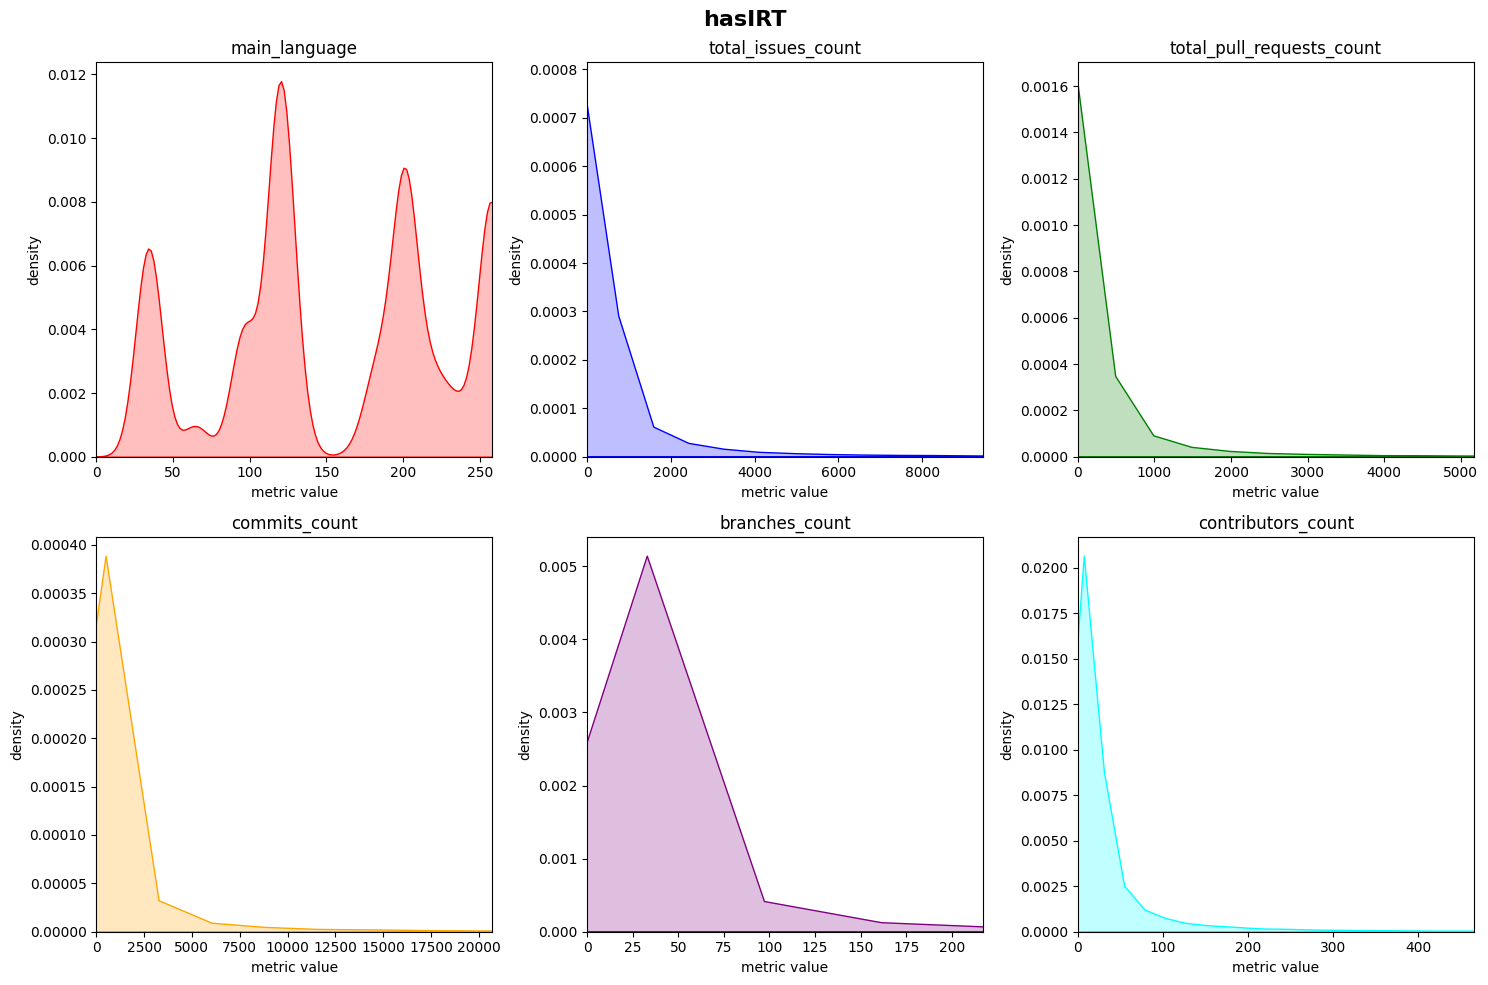

In [34]:
distribution(df_repo_hasIRT, 'hasIRT')

Visualize kernel density plots of repositories with no IRTs

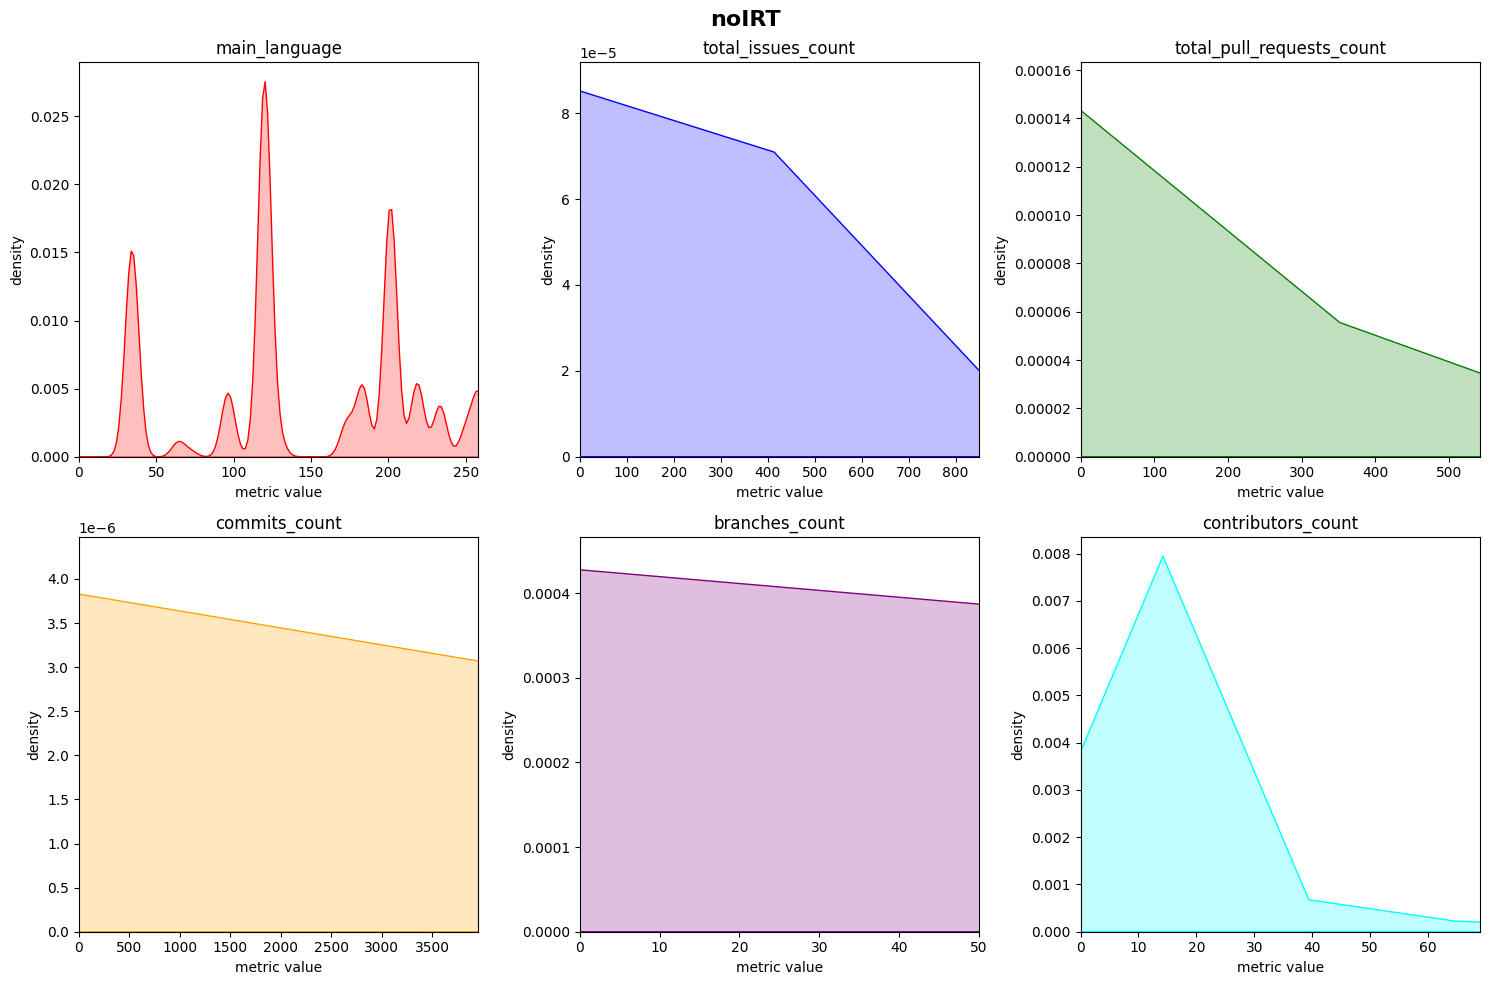

In [90]:
distribution(df_repo_noIRT, 'noIRT')

In [85]:
def boxplots(dataframe1, dataframe2, colors=['red', 'blue', 'green', 'orange', 'purple', 'cyan']):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
    axes = axes.flatten()
    for i in range(len(axes)-1):
        sample = pd.concat([
            dataframe1[[f'{dataframe1.columns[i+1]}', f'{dataframe1.columns[dataframe1.shape[1]-1]}']],
            dataframe2[[f'{dataframe2.columns[i+1]}', f'{dataframe1.columns[dataframe2.shape[1]-1]}']]
        ], ignore_index=True)
        sample['has_IRT'] = np.where(sample['has_IRT'], 1, 0) 
        sns.boxplot(data=sample, y=f'{sample.columns[0]}', x=f'{sample.columns[1]}', ax=axes[i], color=colors[i])
        axes[i].set_title(f'{dataframe1.columns[i+1]}')

    for ax in axes.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)
    plt.tight_layout()
    plt.show()


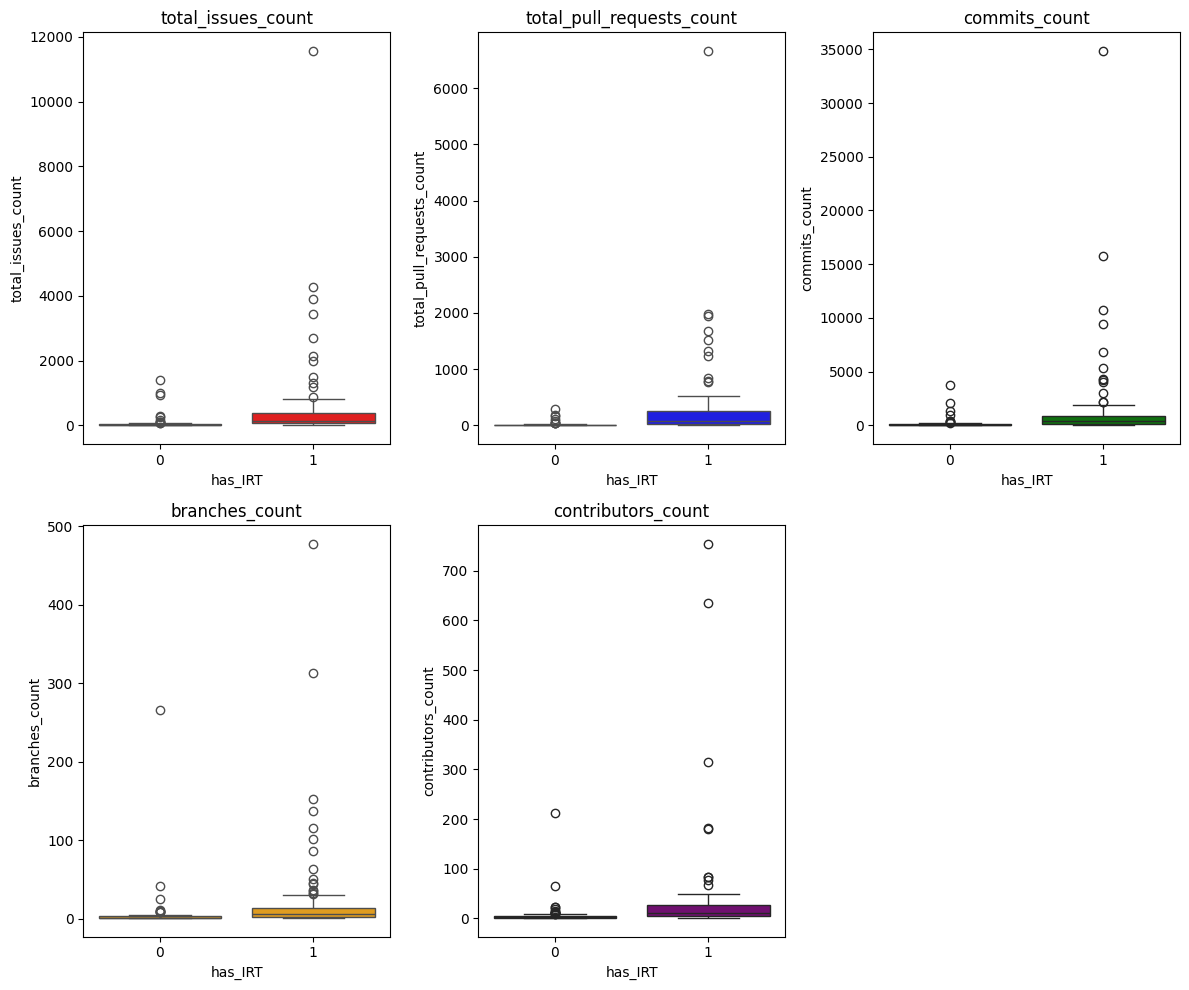

In [86]:
boxplots(df_repo_hasIRT[:100], df_repo_noIRT[:100])

In [87]:
df_repo_hasIRT[['main_language']].describe()

,main_language
count,50032
unique,120
top,201
freq,9139


In [88]:
df_repo_hasIRT.describe()

,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count
count,50032.000000,50032.000000,50032.000000,50032.000000,50032.000000
mean,692.527762,379.188679,1567.750640,18.068956,34.833227
std,2667.991723,1452.136572,6549.474475,93.613874,119.074927
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,37.000000,15.000000,125.000000,2.000000,3.000000
50%,137.000000,66.000000,352.000000,5.000000,9.000000
75%,472.000000,255.000000,1057.250000,14.000000,24.000000
max,164821.000000,97913.000000,546630.000000,12723.000000,4646.000000


In [89]:
df_repo_noIRT.describe()

,total_issues_count,total_pull_requests_count,commits_count,branches_count,contributors_count
count,1.034268e+06,1.034268e+06,1.034268e+06,1.034268e+06,1.034268e+06
mean,5.684081e+01,3.322467e+01,4.832006e+02,4.918488e+00,6.950720e+00
std,3.510778e+02,2.563568e+02,1.190641e+04,1.111781e+02,6.371503e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,0.000000e+00,1.400000e+01,1.000000e+00,1.000000e+00
50%,7.000000e+00,2.000000e+00,4.200000e+01,1.000000e+00,2.000000e+00
75%,2.800000e+01,1.300000e+01,1.340000e+02,3.000000e+00,4.000000e+00
max,9.534700e+04,7.948400e+04,4.314502e+06,1.085890e+05,4.993000e+03
